# SCRITE Demo

This notebook demonstrates how to use the algorithm to infer the phylogeny of the mutations and LOH events in a tumor.

In [8]:
import os
import numpy as np
import pandas as pd

from SCRITE.metropolis_hastings import runMCMC
from SCRITE.output import graphviz, getPosteriorMutationProbabilities, plot_mutation_probabilities, get_cells_annotations
from SCRITE.scores import calculate_llr_mut
from SCRITE.select_variants import * 

### Parameters

In [16]:
# Parameters for the beta-binomial model
params = {"overdispersion_hom":100,"overdispersion_het":2,"dropout":0.8,"sequencing_error_rate":0.005}

# Prior for these parameters
prior_params = {
    "overdispersion_hom":{"min":0,"max":600,"alpha":2,"beta":4},
    "overdispersion_het":{"min":0,"max":4,"alpha":4,"beta":4},
    "dropout":{"min":0,"max":1,"alpha":512,"beta":2048},
    "sequencing_error_rate":{"min":0,"max":1,"alpha":10000,"beta":1000000}
}

# Parameters for the Metropolis-Hastings Algorithm
# Note: here the parameter inference has been disabled
MCMC_params = {
    "probUpdateParams":0, # probability to update the parameters in one step of the algorithm (otherwise the tree is updated)
    "moveProbs": [0.4, 0.35, 0.05], # probabilities of different moves: 
                                # 1.  prune&re-attach: prune a subtree and re-attach it to the main tree
                                # 2.  swap node labels: two nodes are randomly chosen and their labels exchanged
                                # 3.  swap subtrees: swap subtrees only if nodes in different lineages, else prune&re-attach
                                # 1,2 and 3 are weights -> they don't have to sum up to 1
    "reps":1, # number of repetitions of the MCMC
    "loops": 100000, # number of loops within a MCMC,
    "burnInPhase":0.3, # burn-in loops / total number of loops
    "sampleStep":1000,
    "marginalization":True, # if False the program maximizes the placement of the cells, if True the program tries to find the marginal 
                            # distribution of the parameters.
}

### Load the data

Here, I use a smart-seq2 dataset of a glioblastoma patient (patient BT_S2 in [the publication of Darmanis et al., 2017](https://doi.org/10.1016/j.celrep.2017.10.030)) which contains 1169 cells.

In [17]:
data_dir = "Data"
dataset_name = "glioblastoma_BT_S2"


# Counts for the ref allele
df_ref = pd.read_csv(os.path.join(data_dir,dataset_name,"ref.csv"), sep = ",", index_col=0)
# Counts for the alt allele
df_alt = pd.read_csv(os.path.join(data_dir,dataset_name,"alt.csv"), sep = ",", index_col=0)
# SNPs with a high frequency in the population (optional)
if os.path.exists(os.path.join(data_dir,dataset_name,"SNPs.csv")):
    SNPs = set(pd.read_csv(os.path.join(data_dir,dataset_name,"SNPs.csv"), sep = ",",header=None)[0])
else:
    SNPs = None
    
#metadata (for example, which cells were classified as neoplastic, to compare the results)
if os.path.exists(os.path.join(data_dir,dataset_name,"metadata.csv")):
    metadata = pd.read_csv(os.path.join(data_dir,dataset_name,"metadata.csv"),index_col=0)
else:
    metadata = None

### Run Metropolis-Hastings with LOH events
We first run the algorithm with the LOH events. This is used to infer which cells might be neoplastic and which are healthy. If a set of SNPs is given, only these SNPs will be considered at this step. 

The output is a heatmap giving the probability that each cell (columns) has each mutation (rows). The mutations are ordered depending on the best mutation tree, and the cells are ordered depending on their best attachments to the tree.

At mcmc repetition 1/1, step 0 best tree score: -205.17700868146767

At mcmc repetition 1/1, step 10000 best tree score: 6822.504394680271

At mcmc repetition 1/1, step 20000 best tree score: 6916.330016219832

At mcmc repetition 1/1, step 30000 best tree score: 6953.9578176109635

At mcmc repetition 1/1, step 40000 best tree score: 6959.372381221769

At mcmc repetition 1/1, step 50000 best tree score: 6982.869961471901

At mcmc repetition 1/1, step 60000 best tree score: 6986.54600830496

At mcmc repetition 1/1, step 70000 best tree score: 6986.54600830496

At mcmc repetition 1/1, step 80000 best tree score: 6986.54600830496

At mcmc repetition 1/1, step 90000 best tree score: 6986.54600830496

best log score for tree:  6986.54600830496
total #steps after burn-in:  70000.0
percentage of new Parameters accepted: 0.0 %
percentage of Tree moves accepted: 5.119 %


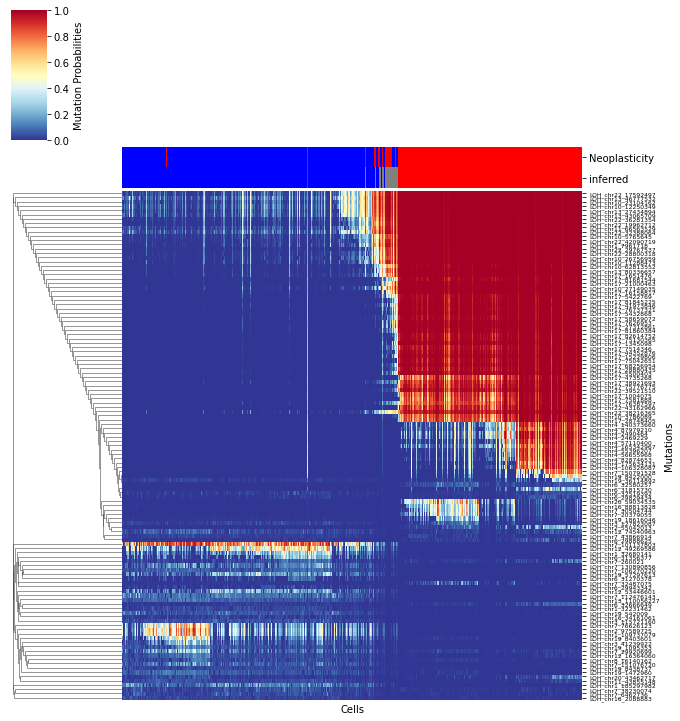

In [18]:
# select LOH events
df_ref_selected,df_alt_selected = select_loci_LOH(df_ref,df_alt,SNPs,minPercentageCellsAllele=7)

#remove cells which do not have enough reads
cells_filtered = list(np.sum((df_ref_selected + df_alt_selected)>0,axis=0) >df_ref_selected.shape[0]/10)
df_ref_selected = df_ref_selected.loc[:,cells_filtered]
df_alt_selected = df_alt_selected.loc[:,cells_filtered]

#Run the Metropolis-Hastings Algorithm
samples, bestTree, bestParams,bestScore,df_mut_prob = \
    runMCMC(MCMC_params, params, prior_params, df_ref_selected,df_alt_selected)

#Identify healthy and neoplastic cells
neoplastic_cells,regular_cells = identify_neoplastic_regular(df_mut_prob)

# Collect annotations for cells:
# Were they classified as neoplastic (in the original publication)
# and did the algorithm infer that they were neoplastic ? 

l=[]
for i in range(df_ref_selected.shape[1]):
    if df_ref_selected.columns[i] in neoplastic_cells:
        l.append("red")
    elif df_ref_selected.columns[i] in regular_cells:
        l.append("blue")
    else:
        l.append("grey")
if metadata is not None:
    cells_annotations = get_cells_annotations(metadata,df_ref_selected.columns)
    cells_annotations["inferred"]=np.array(l)
else:
    cells_annotations=None

# Plot the result
plot_mutation_probabilities(df_mut_prob,bestTree,bestParams,df_ref_selected,df_alt_selected,cells_annotations=cells_annotations)

### Run the Metropolis-Hastings Algorithm with somatic mutations and LOH events

At mcmc repetition 1/1, step 0 best tree score: -993.5183670753981

At mcmc repetition 1/1, step 10000 best tree score: 22916.44628085658

At mcmc repetition 1/1, step 20000 best tree score: 24455.715161077052

At mcmc repetition 1/1, step 30000 best tree score: 24800.18323650939

At mcmc repetition 1/1, step 40000 best tree score: 25054.490559364

At mcmc repetition 1/1, step 50000 best tree score: 25078.048495850067

At mcmc repetition 1/1, step 60000 best tree score: 25232.778040089568

At mcmc repetition 1/1, step 70000 best tree score: 25303.314267348418

At mcmc repetition 1/1, step 80000 best tree score: 25382.85553769652

At mcmc repetition 1/1, step 90000 best tree score: 25436.37844106373

best log score for tree:  25460.037238147997
total #steps after burn-in:  70000.0
percentage of new Parameters accepted: 0.0 %
percentage of Tree moves accepted: 16.871 %


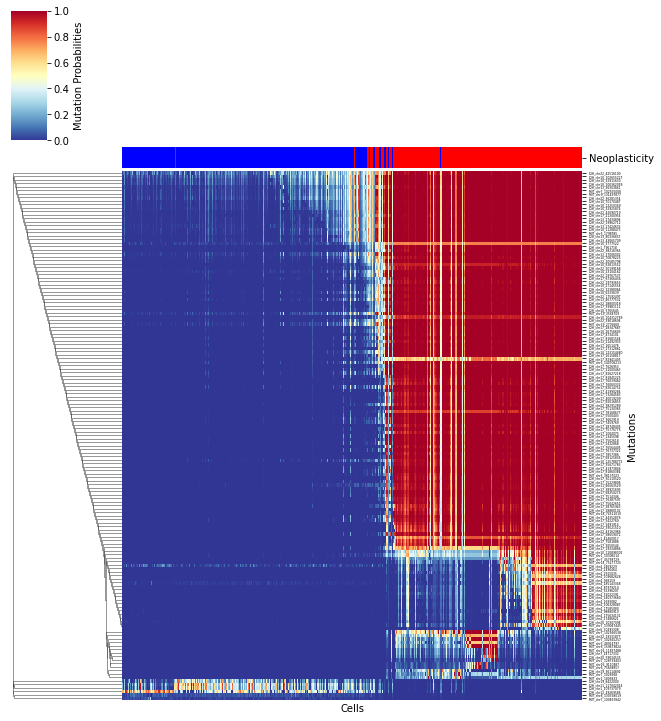

In [19]:
# Use the inferred classification of cells to select candidate somatic mutations and LOH events

df_ref_selected,df_alt_selected = select_loci_classified(df_ref,df_alt, \
                    neoplastic_cells, regular_cells,SNPs,minPercentageCellsExpressed=12)


# Run the Metropolis Hastings algorithm
samples, bestTree, bestParams,bestScore,df_mut_prob = \
    runMCMC(MCMC_params, params, prior_params, df_ref_selected,df_alt_selected)

cells_annotations = get_cells_annotations(metadata,df_ref_selected.columns)
  
    
# Only keep the events which occurred in some cells
selected_events,new_tree = select_events_present(df_mut_prob,bestTree)
df_ref_selected = df_ref_selected.loc[selected_events,:]
df_alt_selected = df_alt_selected.loc[selected_events,:]
df_mut_prob = df_mut_prob.loc[selected_events,:]

plot_mutation_probabilities(df_mut_prob,new_tree,bestParams,df_ref_selected,df_alt_selected,cells_annotations = cells_annotations)



### Compare with the mutation probabilities without using the tree

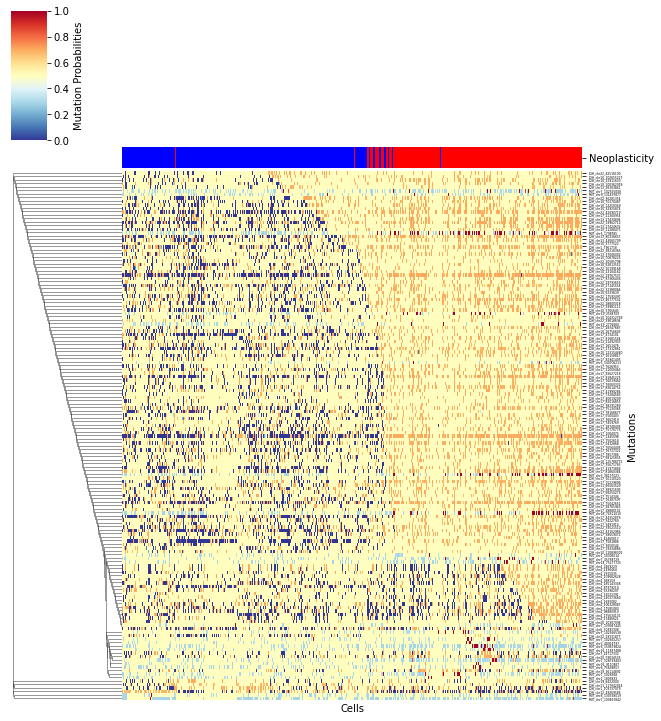

In [20]:
ref = np.array(df_ref_selected)
alt = np.array(df_alt_selected)
bool_LOH = [name[:3]=="LOH" for name in df_ref_selected.index]
indices_LOH = np.where(bool_LOH)[0] 

llr_mut = calculate_llr_mut(bestParams,ref,alt,indices_LOH=indices_LOH)
num_mut = ref.shape[0]
num_cells = ref.shape[1]
p_ref = np.ones((num_mut,num_cells))
p_mut = np.exp(llr_mut)
posterior = np.zeros((num_mut,num_cells))
for i in range(num_mut):
    for j in range(num_cells):
        posterior[i,j] = p_mut[i,j] / (p_mut[i,j] + p_ref[i,j])

df_mut_prob_notree = pd.DataFrame(posterior,index = df_ref_selected.index,columns = df_ref_selected.columns)
plot_mutation_probabilities(df_mut_prob_notree,new_tree,bestParams,df_ref_selected,df_alt_selected,cells_annotations=cells_annotations)